### Libraries

In [1]:
from datasets import load_dataset,Dataset
from datasets.features import Features,Value
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt
import os
from datasets.utils import disable_progress_bar

In [2]:
sns.set(rc={'figure.figsize':(18.7,11.27)})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
disable_progress_bar()

### Data Understanding

In [3]:
#%%capture
#df = load_dataset("csv",data_files=[data_path],skiprows=[0,2_324_812],column_names=columns,features=features_dict)

In [4]:
df = load_dataset("rjac/all-the-news-2-1-Component-one")

Using custom data configuration rjac--all-the-news-2-1-Component-one-7609e9ec7b9659ad


Dataset parquet downloaded and prepared to /home/rjac/.cache/huggingface/datasets/rjac___parquet/rjac--all-the-news-2-1-Component-one-7609e9ec7b9659ad/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


##### Data Exploration

##### Dataset

The datasets consist of News with metada about the author,dates,title, url and the publisher. the article will be use as the main corpus.

In [5]:
df["train"][510:513]

{'idx': [510, 511, 512],
 'article_idx': [510, 511, 512],
 'date': ['2016-11-09 00:00:00', '2018-03-20 19:56:00', '2019-06-19 00:00:00'],
 'year': ['2016', '2018', '2019'],
 'month': ['11.0', '3.0', '6.0'],
 'day': ['9', '20', '19'],
 'author': ['Javier Galeano', 'Patrick Klepek', None],
 'title': ['Anti-Trump protesters gather for third night, one shot in Portland',
  'This Company Specializes In Designing One Specific Thing: Video Game Guns',
  "Britain's Tesco says no timetable for 'finest' store launch"],
 'article': ["MIAMI (Reuters) - Thousands of protesters took their frustrations over Donald Trump’s election as the next U.S. president onto the streets on Friday and into Saturday in several cities, including Portland, Oregon, where one protester was shot.  The unidentified man was wounded on Portland’s Morrison Bridge at 12:45 a.m. local time as he and dozens of other protesters crossed it during their demonstration, one of several across the country denouncing Trump’s campaign 

##### Articles per date

In [6]:
def string_to_datetime(batch):
    """
    Transform string date into a datetime object. it truncates any date into 10 character string 
    assuming a date format of yyyy-mm-dd (Batch function).

    Args:
        batch (datasets.Dataset): batch dataset of the main information 
    Returns:
        result (Dict[datetime:list]): Dictionary with list of datetime object
    """
    dates = batch["date"]
    dates = [date[0:10] for date in dates]
    dates = [datetime.strptime(date,'%Y-%m-%d') for date in dates]
    return {"datetime":dates}

In [7]:
%%capture
df = df.map(string_to_datetime,batched=True,num_proc=10)

<AxesSubplot:ylabel='count'>

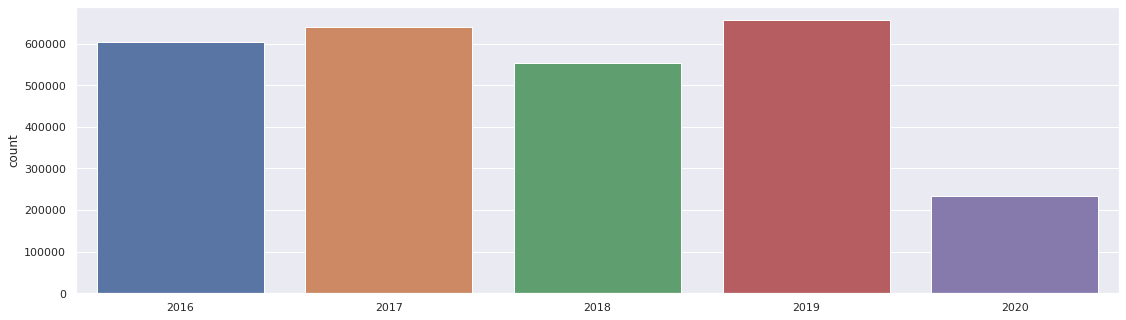

In [9]:
sns.set(rc={'figure.figsize':(18.7,5.27)})
sns.countplot(x=[d.year for d in df["train"]["datetime"]])

In [10]:
dates_of_articles = pd.DataFrame({"dates":df["train"]["datetime"]})

In [11]:
dates_of_articles["year"] = dates_of_articles.dates.dt.year
dates_of_articles["months"] = dates_of_articles.dates.dt.month

In [12]:
months_per_year = dates_of_articles.groupby(["year","months"]).count().unstack()
months_per_year.columns = [1,2,3,4,5,6,7,8,9,110,11,12]

<AxesSubplot:ylabel='year'>

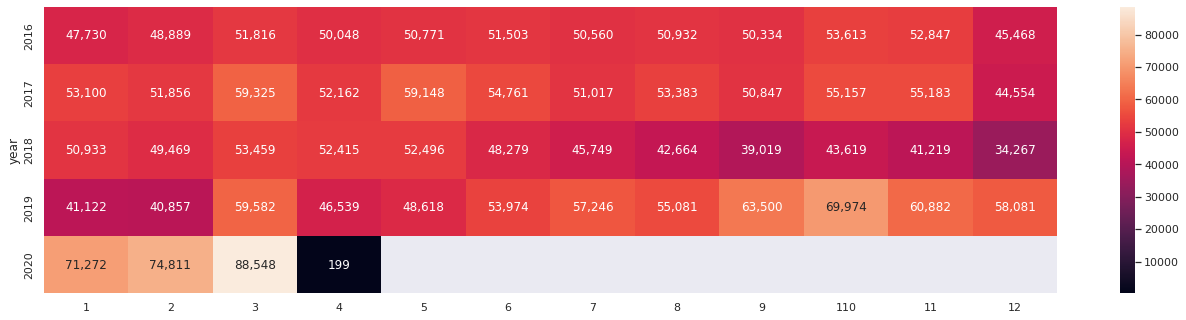

In [13]:
sns.set(rc={'figure.figsize':(22.7,5.27)})
sns.heatmap(months_per_year,annot=True,fmt=",.0f")

### Publication site

<AxesSubplot:ylabel='count'>

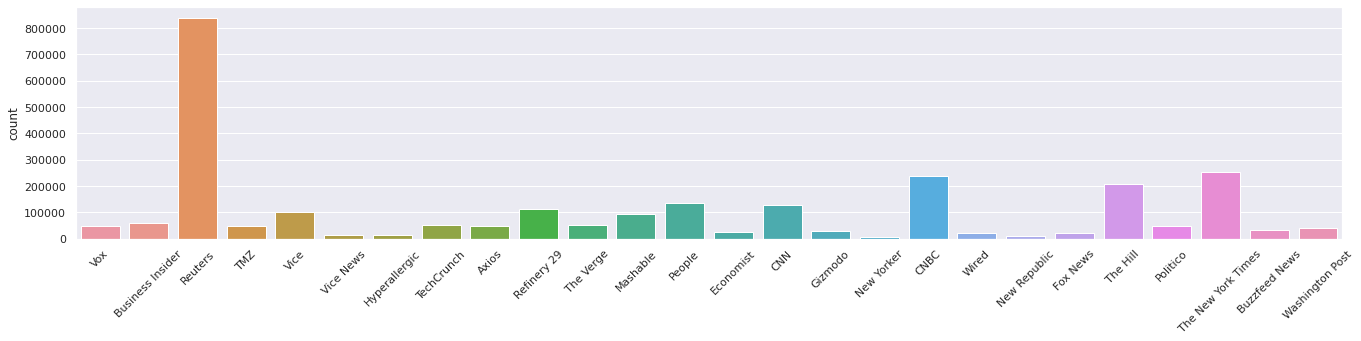

In [14]:
sns.set(rc={'figure.figsize':(22.7,4.27)})
plt.xticks(rotation=45)
sns.countplot(x=df["train"]["publication"])

### Tokens (Words) and Sentences per Article

In [56]:
def token_count(batch):
    """
    Split the article text into tokens and count the number of it (Batch function).

    Args:
        batch (datasets.Dataset): batch dataset of the main information 
    Returns:
        result (Dict[tokens:list,article_len:list]): Dictionary with number of token per article and the corresponding tokens
    """
    articles = batch["article"]
    articles_tokens = [[] if article == None else article.split() for article in articles]
    len_articles_token = [len(tokens) for tokens in articles_tokens ]
    result = {"tokens":articles_tokens,"article_len":len_articles_token}
    return result

def sentence_count(batch):
    """
    Split the article text into sentence base over the punctuation (Batch function).

    Args:
        batch (datasets.Dataset): batch dataset of the main information 
    Returns:
        result (Dict[tokens:list,article_len:list]): Dictionary with number of token per article and the corresponding tokens
    """
    articles = batch["article"]
    articles_sentences = [[] if article == None else article.split(".") for article in articles]
    #Consider a full sentence if it has more than 25 Character - TODO Improvement with nltk sentence tokenizer
    len_articles_sent = [len(sent) for sent in articles_sentences]
    result = {"number_of_sentences":len_articles_sent}
    return result



In [54]:
df = df.map(token_count,batched=True,num_proc=10)

In [57]:
df = df.map(sentence_count,batched=True,num_proc=10)

### Tokens per Article

<AxesSubplot:ylabel='Count'>

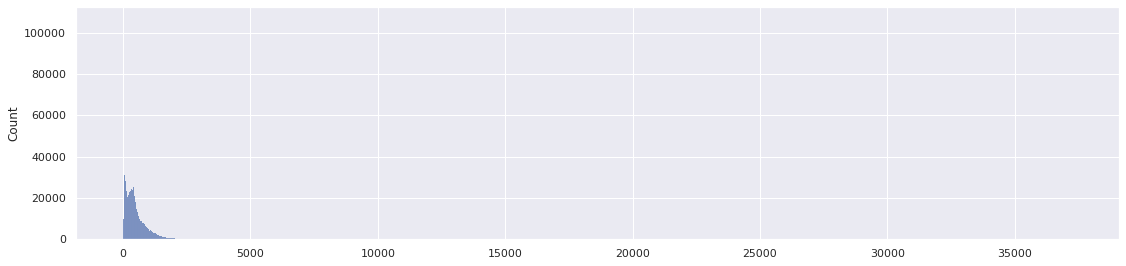

In [ ]:
sns.set(rc={'figure.figsize':(18.7,4.27)})
sns.histplot(x=df["train"]["article_len"]) 

If we remove outliers (base on Boxplot Interquartile range) , we can visualize that every Article could contain from 200 to 650 words. We have news without article and longer News thatvary from 800 to 1,400 words. considering the max value is 37k words 

<AxesSubplot:>

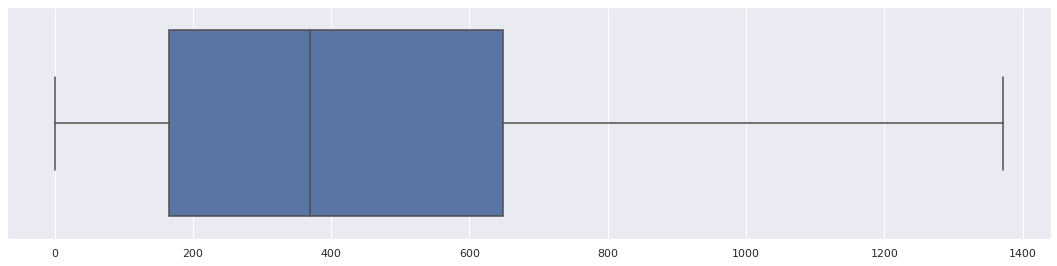

In [ ]:
sns.set(rc={'figure.figsize':(18.7,4.27)})
sns.boxplot(x=df["train"]["article_len"],showfliers = False) 


In [ ]:
pd.DataFrame({"len":df["train"]["article_len"]}).describe().T

,count,mean,std,min,25%,50%,75%,max
len,2688878.000,495.779,566.953,0.000,165.000,370.000,648.000,37240.000


### Sentences per Article

<AxesSubplot:ylabel='Count'>

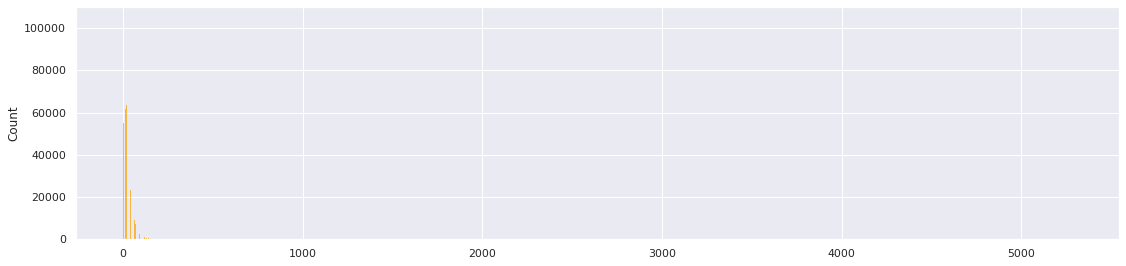

In [62]:
sns.set(rc={'figure.figsize':(18.7,4.27)})
sns.histplot(x=df["train"]["number_of_sentences"],color="orange") 

<AxesSubplot:>

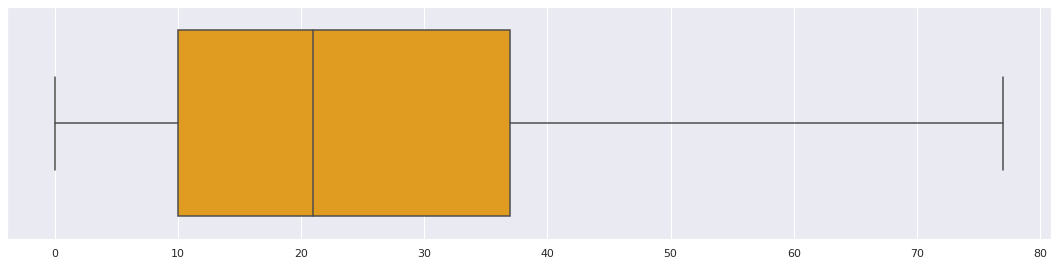

In [63]:
sns.set(rc={'figure.figsize':(18.7,4.27)})
sns.boxplot(x=df["train"]["number_of_sentences"],showfliers = False,color="orange") 

In [61]:
pd.DataFrame({"len":df["train"]["number_of_sentences"]}).describe().T

,count,mean,std,min,25%,50%,75%,max
len,2688878.000,28.757,37.433,0.000,10.000,21.000,37.000,5280.000
